# Fit Example Using Nelder-Mead Simplex Algorithm From `scipy`

This example shows how to apply Nelder-Mead simplex algorithm from `scipy` to the linear interpolant provided by `nevis`, so as to find a local maximum on the GB height map.

## Optimisation

Ensure that you have downloaded the OS Terrain data:

In [1]:
import nevis
nevis.download_os_terrain_50()
nevis.howdy() # Print the current version number

Downloaded, unpacked, and processed file already found: Skipping.

                |>          
 Starting Ben   |   Nevis   
               / \    Local
            /\/---\     0.0.5
           /---    \/\      
        /\/   /\   /  \     
     /\/  \  /  \_/    \    
    /      \/           \   


First, we load the linear interpolant on the GB height data from `nevis`. The interpolant takes two arguments, the coordinates x and y, and returns a scalar height. We then get the dimensions of the data, later used as bounds for optimisation.

In [2]:
f = nevis.linear_interpolant()
x_max, y_max = nevis.dimensions()

Let's focus on a neighborhood of the hill of [Schiehallion](https://en.wikipedia.org/wiki/Schiehallion) (in Scotland) and plot this region:

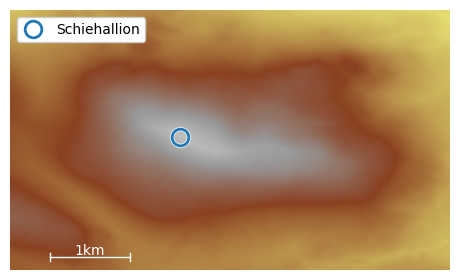

In [3]:
import matplotlib.pyplot as plt
hill, boundaries = nevis.schiehallion()
nevis.plot(
    boundaries=boundaries,
    labels={
        hill.name: hill.coords
    },
    upsampling=4,
)
plt.show()

We define a wrapper around `f` to count the number of evaluations, use a list to remember visited points, and create a callback to update the list and print relevant information:

In [4]:
eval_cnt = 0
def wrapper(x):
    global eval_cnt
    eval_cnt += 1
    return -f(*x)

points = []
def callback(xk):
    points.append(xk)
    if len(points) % 20 == 0:
        print(f'Number of iterations: {len(points)}, number of evaluations: {eval_cnt}')

Next, we optimise the interpolant in this region using [Nelder-Mead Simplex algorithm](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#id22). We randomly select a point in this region as `x0`. Note that we need a minus sign before our `f` to convert our problem to minimisation.

In [5]:
from scipy.optimize import minimize
import numpy as np

x1, x2, y1, y2 = boundaries
a = np.random.rand() * (x2 - x1) + x1
b = np.random.rand() * (y2 - y1) + y1

result = minimize(
    wrapper,
    x0=(a, b),
    bounds=[(x1, x2), (y1, y2)],
    callback=callback,
    method='Nelder-Mead'
)

Number of iterations: 20, number of evaluations: 38
Number of iterations: 40, number of evaluations: 78
Number of iterations: 60, number of evaluations: 115


We then obtain the solution point and its corresponding function value. To find out where the optimiser has taken us to, we print the formatted result:

In [6]:
x, y = result.x
z = -result.fun
nevis.print_result(x, y, z)

Congratulations!
You landed at an altitude of 1082m.
  https://opentopomap.org/#marker=15/56.666982/-4.100378
You are 11m from the nearest named hill top, "Schiehallion",
  ranked the 115th heighest in GB.
  http://hillsummits.org.uk/htm_summit/103.htm


We also print the total number of function evaluations for benchmarking:

In [7]:
print(f'Number of function evaluations: {result.nfev}.')

Number of function evaluations: 129.


## Plot

Some preparations for plotting the optimisation results:

In [8]:
points = np.array(points)
c = nevis.Coords(gridx=x, gridy=y)

Figure 1: A zoomed map with your location and visted points:

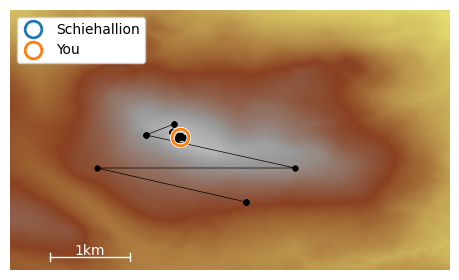

In [9]:
labels = {
    hill.name: hill.coords,
    'You': c,
}
nevis.plot(
    boundaries=boundaries,
    labels=labels,
    trajectory=points,
    upsampling=4,
)
plt.show()

Figure 2: Height along the line from Schiehallion to our location (note that there might be some discrepancies between a local maximum point of the interpolant and the corresponding hill in the database):

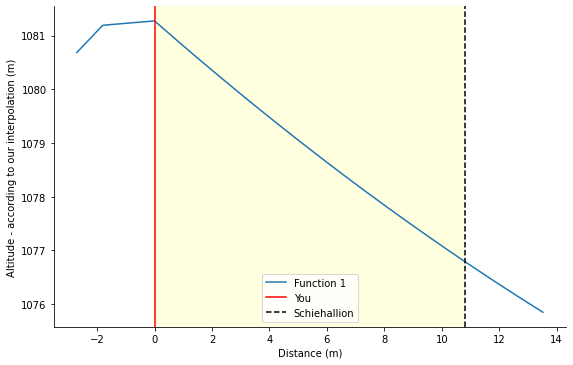

In [10]:
nevis.plot_line(f, c, hill.coords, 'You', hill.name)
plt.show()